# Download the dataset

In [1]:
import os
import requests
import zipfile
import io

dataset_url = "https://www.kaggle.com/api/v1/datasets/download/firecastrl/us-wildfire-dataset"
destination = "Wildfire_Dataset.csv"
if os.path.isfile(destination) == False:
    print(f"Downloading dataset from {dataset_url}...")
    zip = requests.get(dataset_url, allow_redirects=True)
    zipfile.ZipFile(io.BytesIO(zip.content)).extractall()
else:
    print(f"{destination} already exists. Skipping download.")

print("Dataset is ready.")

Wildfire_Dataset.csv already exists. Skipping download.
Dataset is ready.


# Dataset Shape

In [2]:
import pandas as pd

df = pd.read_csv("Wildfire_Dataset.csv", parse_dates=["datetime"])

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\n")
df.head()

Shape: (9509925, 19)

Columns: ['latitude', 'longitude', 'datetime', 'Wildfire', 'pr', 'rmax', 'rmin', 'sph', 'srad', 'tmmn', 'tmmx', 'vs', 'bi', 'fm100', 'fm1000', 'erc', 'etr', 'pet', 'vpd']




,latitude,longitude,datetime,Wildfire,pr,rmax,rmin,sph,srad,tmmn,tmmx,vs,bi,fm100,fm1000,erc,etr,pet,vpd
0,48.128431,-97.276685,2018-08-15,No,0.0,78.6,14.9,0.00582,272.6,282.0,301.6,3.0,40.0,10.2,12.2,54.0,7.5,5.5,1.59
1,48.128431,-97.276685,2018-08-16,No,0.0,80.4,13.9,0.00676,264.0,283.9,304.9,3.0,40.0,9.7,12.0,56.0,8.2,5.9,1.93
2,48.128431,-97.276685,2018-08-17,No,0.0,70.9,20.4,0.00672,265.6,285.8,300.7,3.1,40.0,9.2,11.9,56.0,7.2,5.3,1.51
3,48.128431,-97.276685,2018-08-18,No,5.0,65.2,19.4,0.00756,261.4,289.0,303.3,5.1,0.0,9.9,12.0,40.0,10.0,6.9,1.85
4,48.128431,-97.276685,2018-08-19,No,0.0,100.0,42.2,0.00895,166.8,283.8,296.5,4.7,41.0,11.8,12.1,47.0,4.6,3.4,0.66


# Class Distribution

Wildfire
No     9007860
Yes     502065
Name: count, dtype: int64




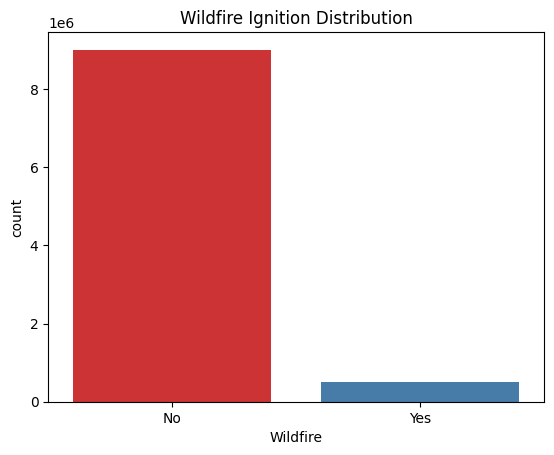

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

print(df["Wildfire"].value_counts())
print("\n")

sns.countplot(x="Wildfire", data=df, hue="Wildfire", palette="Set1", legend=False)
plt.title("Wildfire Ignition Distribution")
plt.show()

# Drop Datapoints Missing Meteorological Data

In [4]:
fill_value = 32767.0
mask = ~(df == fill_value).any(axis=1)
df = df.loc[mask].reset_index(drop=True)
print("Shape:", df.shape)
df.head()

Shape: (9484200, 19)


,latitude,longitude,datetime,Wildfire,pr,rmax,rmin,sph,srad,tmmn,tmmx,vs,bi,fm100,fm1000,erc,etr,pet,vpd
0,48.128431,-97.276685,2018-08-15,No,0.0,78.6,14.9,0.00582,272.6,282.0,301.6,3.0,40.0,10.2,12.2,54.0,7.5,5.5,1.59
1,48.128431,-97.276685,2018-08-16,No,0.0,80.4,13.9,0.00676,264.0,283.9,304.9,3.0,40.0,9.7,12.0,56.0,8.2,5.9,1.93
2,48.128431,-97.276685,2018-08-17,No,0.0,70.9,20.4,0.00672,265.6,285.8,300.7,3.1,40.0,9.2,11.9,56.0,7.2,5.3,1.51
3,48.128431,-97.276685,2018-08-18,No,5.0,65.2,19.4,0.00756,261.4,289.0,303.3,5.1,0.0,9.9,12.0,40.0,10.0,6.9,1.85
4,48.128431,-97.276685,2018-08-19,No,0.0,100.0,42.2,0.00895,166.8,283.8,296.5,4.7,41.0,11.8,12.1,47.0,4.6,3.4,0.66


# Wildfire by Lat/Long

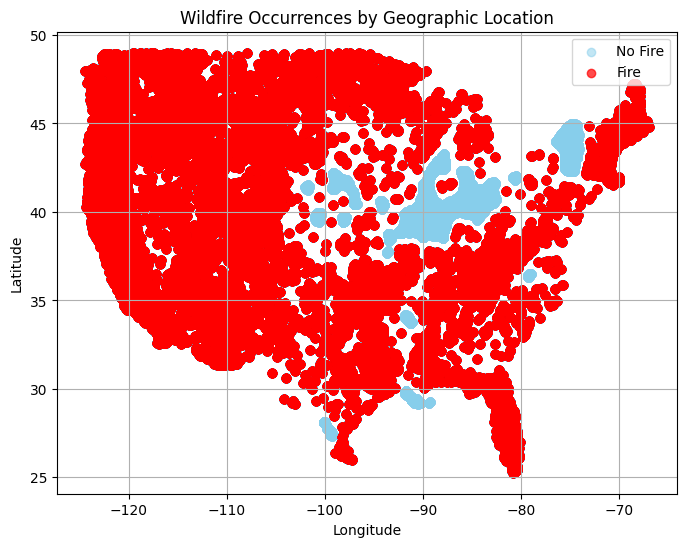

In [5]:
plt.figure(figsize=(8, 6))

# No fire
plt.scatter(
    df[df["Wildfire"] == "No"]["longitude"],
    df[df["Wildfire"] == "No"]["latitude"],
    color="skyblue",
    label="No Fire",
    alpha=0.5,
)

# fire
plt.scatter(
    df[df["Wildfire"] == "Yes"]["longitude"],
    df[df["Wildfire"] == "Yes"]["latitude"],
    color="red",
    label="Fire",
    alpha=0.7,
)

plt.title("Wildfire Occurrences by Geographic Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Add Month, Year, Day of Year to Columns

In [6]:
# Convert datetime column
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

# Create columns for exploration
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["dayofyear"] = df["datetime"].dt.dayofyear

# Split Data Into 75 Day Blocks

In [7]:
import numpy as np
SEQ_LEN = 75

df = df.sort_values(["latitude", "longitude", "datetime"]).reset_index(drop=True)
df["seq_id"] = np.arange(len(df)) // SEQ_LEN
groups = list(df.groupby("seq_id"))

FEATURES = [
    "pr",
    "rmax",
    "rmin",
    "sph",
    "srad",
    "tmmn",
    "tmmx",
    "vs",
    "bi",
    "fm100",
    "fm1000",
    "erc",
    "etr",
    "pet",
    "vpd",
]

# (n_seq, 75, n_features)
seqs = np.stack([g[FEATURES].values for _, g in groups], axis=0)

# 1 if any wildfire in the 75-day block, else 0
labels = np.array([int((g["Wildfire"] == "Yes").any()) for _, g in groups])


print("Sequences:", seqs.shape, " Labels:", labels.shape)

# Split data from 2014-2022 for training and 2023-2025 for testing

train_seqs = [] 
train_labels = []

test_seqs = []
test_labels = []

for (seq_id, g) in groups:
    year = g["year"].iloc[0]
    seq = g[FEATURES].values
    label = int((g["Wildfire"] == "Yes").any())
    
    if year <= 2022:
        train_seqs.append(seq)
        train_labels.append(label)
    else:
        test_seqs.append(seq)
        test_labels.append(label)
train_x = np.array(train_seqs)
train_y = np.array(train_labels)

test_x = np.array(test_seqs)
test_y = np.array(test_labels)

print("Train sequences:", train_x.shape, " Train labels:", train_y.shape)
print("Test sequences:", test_x.shape, " Test labels:", test_y.shape)
n_samples, n_timesteps, n_features = train_x.shape
train_x = train_x.reshape((n_samples, n_timesteps * n_features))
n_samples, n_timesteps, n_features = test_x.shape
test_x = test_x.reshape((n_samples, n_timesteps * n_features))
print("Reshaped Train sequences:", train_x.shape)
print("Reshaped Test sequences:", test_x.shape)




Sequences: (126456, 75, 15)  Labels: (126456,)
Train sequences: (116034, 75, 15)  Train labels: (116034,)
Test sequences: (10422, 75, 15)  Test labels: (10422,)
Reshaped Train sequences: (116034, 1125)
Reshaped Test sequences: (10422, 1125)


# Standardize The Data

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

# Logistic Regression Training

In [9]:
model = LogisticRegression(max_iter=1000)
model.fit(train_x, train_y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


# Evaluation

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(test_x)
acc = accuracy_score(test_y, y_pred)

print(f"Accuracy: {acc:.3f}")
print("Confusion Matrix:\n", confusion_matrix(test_y, y_pred))
print("\nClassification Report:\n", classification_report(test_y, y_pred))

Accuracy: 0.331
Confusion Matrix:
 [[3139   30]
 [6939  314]]

Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.99      0.47      3169
           1       0.91      0.04      0.08      7253

    accuracy                           0.33     10422
   macro avg       0.61      0.52      0.28     10422
weighted avg       0.73      0.33      0.20     10422

